![Exploratory Data Analysis](https://assets.datacamp.com/production/course_15300/shields/thumb/shield_image_course_15300_20200306-1-9ipu3?1583530061)

# Read, clean, and validate

## Exploring the NSFG data

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, linregress
import seaborn as sns

%matplotlib inline

In [2]:
nsfg = pd.read_csv("../datasets/nsfg.csv")
nsfg.head()

,caseid,outcome,birthwgt_lb1,birthwgt_oz1,prglngth,nbrnaliv,agecon,agepreg,hpagelb,wgt2013_2015
0,60418,1,5.0,4.0,40,1.0,2000,2075.0,22.0,3554.964843
1,60418,1,4.0,12.0,36,1.0,2291,2358.0,25.0,3554.964843
2,60418,1,5.0,4.0,36,1.0,3241,3308.0,52.0,3554.964843
3,60419,6,NaN,NaN,33,NaN,3650,NaN,NaN,2484.535358
4,60420,1,8.0,13.0,41,1.0,2191,2266.0,24.0,2903.782914


### Number of Rows and Columns

In [3]:
nsfg.shape

(9358, 10)

### Column Names

In [4]:
nsfg.columns

Index(['caseid', 'outcome', 'birthwgt_lb1', 'birthwgt_oz1', 'prglngth',
       'nbrnaliv', 'agecon', 'agepreg', 'hpagelb', 'wgt2013_2015'],
      dtype='object')

In [5]:
ounces = nsfg.birthwgt_oz1
ounces.head()

0     4.0
1    12.0
2     4.0
3     NaN
4    13.0
Name: birthwgt_oz1, dtype: float64

## Clean and Validate

### Validate a variable

`'outcome'` encodes the outcome of each pregnancy as shown below:

```python
value	label
1	    Live birth
2	    Induced abortion
3	    Stillbirth
4	    Miscarriage
5	    Ectopic pregnancy
6	    Current pregnancy
```

In [6]:
nsfg.outcome.value_counts().sort_index()

1    6489
2     947
3      86
4    1469
5     118
6     249
Name: outcome, dtype: int64

### Clean a variable

`'nbrnaliv'` records the number of babies born alive at the end of a pregnancy.

In [7]:
nsfg.nbrnaliv.value_counts().sort_index()

1.0    6379
2.0     100
3.0       5
8.0       1
Name: nbrnaliv, dtype: int64

`8` appears once this value indicates that the respondent refused to answer the question. we will clean this

In [8]:
nsfg.nbrnaliv.replace(8, np.nan, inplace=True)
display(nsfg.nbrnaliv.value_counts().sort_index())

nsfg.birthwgt_lb1.replace([98, 99], np.nan, inplace=True)
display(nsfg.birthwgt_lb1.value_counts().sort_index())

nsfg.birthwgt_oz1.replace([98, 99], np.nan, inplace=True)
display(nsfg.birthwgt_oz1.value_counts().sort_index())

1.0    6379
2.0     100
3.0       5
Name: nbrnaliv, dtype: int64

0.0        6
1.0       34
2.0       47
3.0       67
4.0      196
5.0      586
6.0     1666
7.0     2146
8.0     1168
9.0      363
10.0      82
11.0      17
12.0       7
13.0       2
14.0       2
17.0       1
Name: birthwgt_lb1, dtype: int64

0.0     757
1.0     297
2.0     429
3.0     393
4.0     386
5.0     407
6.0     543
7.0     346
8.0     518
9.0     377
10.0    295
11.0    418
12.0    388
13.0    275
14.0    258
15.0    268
Name: birthwgt_oz1, dtype: int64

### Compute a variable

For each pregnancy in the NSFG dataset, the variable 'agecon' encodes the respondent's age at conception, and `'agepreg'` the respondent's age at the end of the pregnancy.

Both variables are recorded as integers with two implicit decimal places, so the value `2575` means that the respondent's age was `25.75`.

In [9]:
# Compute the difference
nsfg['preg_length'] = (nsfg.agepreg/100) - (nsfg.agecon/100)

# Compute summary statistics
nsfg.preg_length.describe()

count    9109.000000
mean        0.552069
std         0.271479
min         0.000000
25%         0.250000
50%         0.670000
75%         0.750000
max         0.920000
Name: preg_length, dtype: float64

## Filter and visualize


### Make a histogram

> Histograms are one of the most useful tools in exploratory data analysis. They quickly give you an overview of the distribution of a variable, that is, what values the variable can have, and how many times each value appears.

the NSFG dataset includes a variable `'agecon'` that records age at conception for each pregnancy. Here, we're going to plot a histogram of this variable.

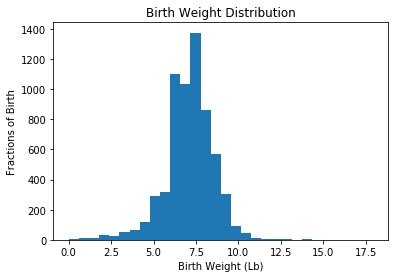

In [10]:
nsfg['birth_weight'] = nsfg.birthwgt_lb1 + nsfg.birthwgt_oz1/16.0
plt.hist(nsfg.birth_weight.dropna(), bins=30)
plt.xlabel("Birth Weight (Lb)")
plt.ylabel("Fractions of Birth")
plt.title("Birth Weight Distribution")
plt.show()

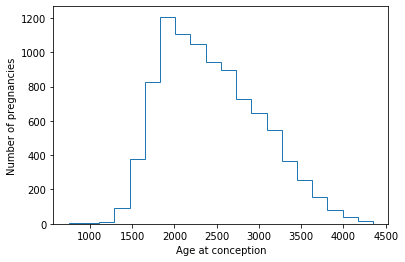

In [11]:
# Plot the histogram
plt.hist(nsfg.agecon, bins=20, histtype='step')

# Label the axes
plt.xlabel('Age at conception')
plt.ylabel('Number of pregnancies')

# Show the figure
plt.show()

### Compute birth weight

compute the average birth weight for full-term babies.

In [12]:
def resample_rows_weighted(df, column='finalwgt', seed=17):
    """Resamples a DataFrame using probabilities proportional to given column.

    df: DataFrame
    column: string column name to use as weights

    returns: DataFrame
    """
    np.random.seed(seed)
    weights = df[column] / sum(df[column])
    indices = np.random.choice(df.index, len(df), replace=True, p=weights)
    sample = df.loc[indices]
    return sample

In [13]:
# Resample the data
nsfg = resample_rows_weighted(nsfg, 'wgt2013_2015')

# Clean the weight variables
pounds = nsfg['birthwgt_lb1'].replace([98, 99], np.nan)
ounces = nsfg['birthwgt_oz1'].replace([98, 99], np.nan)

# Compute total birth weight
birth_weight = pounds + ounces/16

In [14]:
# Create a Boolean Series for full-term babies
full_term = nsfg.prglngth>=37

# Select the weights of full-term babies
full_term_weight = birth_weight[full_term]

# Compute the mean weight of full-term babies
full_term_weight.mean()

7.392597951914515

### Filter

In [15]:
# Filter full-term babies
full_term = nsfg['prglngth'] >= 37

# Filter single births
single = nsfg.nbrnaliv==1

# Compute birth weight for single full-term babies
single_full_term_weight = birth_weight[full_term & single]
print('Single full-term mean:', single_full_term_weight.mean())

# Compute birth weight for multiple full-term babies
mult_full_term_weight = birth_weight[full_term & ~single]
print('Multiple full-term mean:', mult_full_term_weight.mean())


Single full-term mean: 7.40297320308299
Multiple full-term mean: 5.784722222222222


# Distributions

* Represent distributions using Probability Mass Functions (PMFs) and Cumulative Distribution Functions (CDFs). 

## Probability mass functions

### Make a PMF

In [18]:
from empiricaldist import Pmf,Cdf

In [19]:
gss = pd.read_csv("../datasets/gss.csv")
gss.head()

,year,sex,age,cohort,race,educ,realinc,wtssall
0,1972,1,26.0,1946.0,1,18.0,13537.0,0.8893
1,1972,2,38.0,1934.0,1,12.0,18951.0,0.4446
2,1972,1,57.0,1915.0,1,12.0,30458.0,1.3339
3,1972,2,61.0,1911.0,1,14.0,37226.0,0.8893
4,1972,1,59.0,1913.0,1,12.0,30458.0,0.8893


In [20]:
# Compute the PMF for year
pmf_year = Pmf.from_seq(gss.year, normalize=False)

# Print the result
print(pmf_year)

1972    1613
1973    1504
1974    1484
1975    1490
1976    1499
1977    1530
1978    1532
1980    1468
1982    1860
1983    1599
1984    1473
1985    1534
1986    1470
1987    1819
1988    1481
1989    1537
1990    1372
1991    1517
1993    1606
1994    2992
1996    2904
1998    2832
2000    2817
2002    2765
2004    2812
2006    4510
2008    2023
2010    2044
2012    1974
2014    2538
2016    2867
Name: year, dtype: int64


### Plot a PMF

 PMF for the age of the respondents in the GSS dataset. The variable `'age'` contains respondents' age in years.

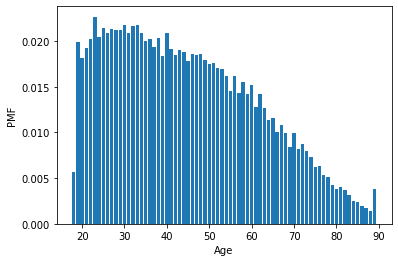

In [21]:
# Plot the PMF
Pmf.from_seq(gss.age).bar()

# Label the axes
plt.xlabel('Age')
plt.ylabel('PMF')
plt.show()

## Cumulative distribution functions

### Make a CDF

In [22]:
# Compute the CDF of age
cdf_age = Cdf.from_seq(gss.age)

# Calculate the CDF of 30
cdf_age(30)

array(0.25391371)

### Compute IQR

compute the interquartile range of income in the GSS dataset. Income is stored in the `'realinc'` column, and the CDF of income has already been computed and stored in `cdf_income`.

In [23]:
cdf_income = Cdf.from_seq(gss.realinc)
cdf_income.inverse(.75) - cdf_income.inverse(.25)

29676.0

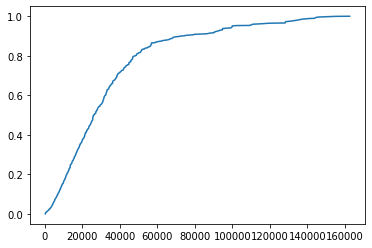

In [24]:
cdf_income.plot()

## Comparing distributions

### Distribution of sex

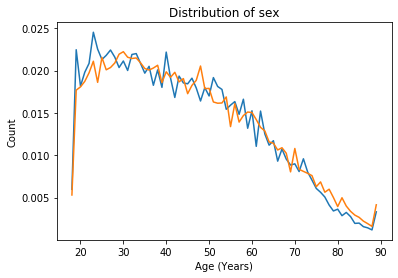

In [25]:
Pmf.from_seq(gss.age[gss.sex==1]).plot(label="Male")
Pmf.from_seq(gss.age[~(gss.sex==1)]).plot(label="Female")
plt.xlabel("Age (Years)")
plt.ylabel("Count")
plt.title("Distribution of sex")
plt.show()

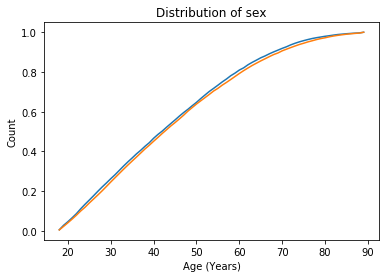

In [26]:
Cdf.from_seq(gss.age[gss.sex==1]).plot(label="Male")
Cdf.from_seq(gss.age[~(gss.sex==1)]).plot(label="Female")
plt.xlabel("Age (Years)")
plt.ylabel("Count")
plt.title("Distribution of sex")
plt.show()

### Income Distribution

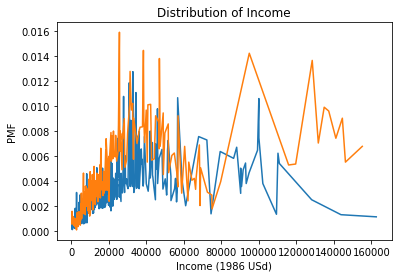

In [27]:
Pmf.from_seq(gss.realinc[gss.year<1995]).plot(label="Before 1995")
Pmf.from_seq(gss.realinc[~(gss.year<1995)]).plot(label="After 1995")
plt.xlabel("Income (1986 USd)")
plt.ylabel("PMF")
plt.title("Distribution of Income")
plt.show()

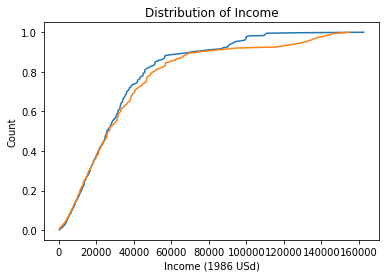

In [28]:
Cdf.from_seq(gss.realinc[gss.year<1995]).plot(label="Before 1995")
Cdf.from_seq(gss.realinc[~(gss.year<1995)]).plot(label="After 1995")
plt.xlabel("Income (1986 USd)")
plt.ylabel("Count")
plt.title("Distribution of Income")
plt.show()

### Distribution of education

#### Extract education levels

In the U.S, 12 years of education usually means the respondent has completed high school (secondary education). A respondent with 14 years of education has probably completed an associate degree (two years of college); someone with 16 years has probably completed a bachelor's degree (four years of college).

In [29]:
# Select educ
educ = gss['educ']

# Bachelor's degree
bach = (educ >= 16)

# Associate degree
assc = (educ>=14) & (educ<16)

# High school (12 or fewer years of education)
high = (educ <= 12)
high.mean()

0.5308807991547402

### Plot income CDFs

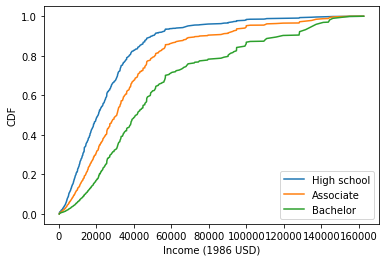

In [30]:
income = gss['realinc']

# Plot the CDFs
Cdf.from_seq(income[high]).plot(label='High school')
Cdf.from_seq(income[assc]).plot(label='Associate')
Cdf.from_seq(income[bach]).plot(label='Bachelor')

# Label the axes
plt.xlabel('Income (1986 USD)')
plt.ylabel('CDF')
plt.legend()
plt.show()

 It might not be surprising that people with more education have higher incomes, but looking at these distributions, we can see where the differences are.
 
 ## Modeling distributions
### Distribution of income

In [31]:
# Extract realinc and compute its log
income = gss['realinc']
log_income = np.log10(income)

# Compute mean and standard deviation
mean = log_income.mean()
std = log_income.std()
print(mean, std)

# Make a norm object
from scipy.stats import norm
dist = norm(mean,std)

4.371148677934171 0.4290082383271385


### Comparing CDFs

To see whether the distribution of income is well modeled by a lognormal distribution, we'll compare the CDF of the logarithm of the data to a normal distribution with the same mean and standard deviation. 

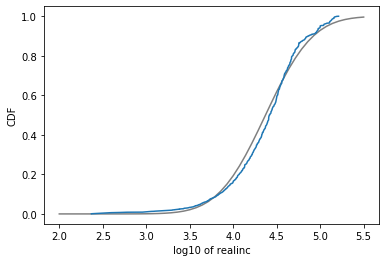

In [32]:
# Evaluate the model CDF
xs = np.linspace(2, 5.5)
ys = dist.cdf(xs)

# Plot the model CDF
plt.clf()
plt.plot(xs, ys, color='gray')

# Create and plot the Cdf of log_income
Cdf.from_seq(log_income).plot(label="log_income")
    
# Label the axes
plt.xlabel('log10 of realinc')
plt.ylabel('CDF')
plt.show()

The lognormal model is a pretty good fit for the data, but clearly not a perfect match.

### Comparing PDFs

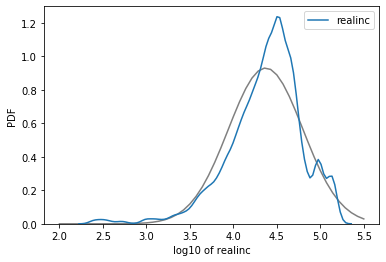

In [33]:
# Evaluate the normal PDF
xs = np.linspace(2, 5.5)
ys = dist.pdf(xs)

# Plot the model PDF
plt.clf()
plt.plot(xs, ys, color='gray')

# Plot the data KDE
sns.kdeplot(log_income)

# Label the axes
plt.xlabel('log10 of realinc')
plt.ylabel('PDF')
plt.show()

# Relationships

explore relationships between variables two at a time, using scatter plots and other visualizations to extract insights from a new dataset obtained from the Behavioral Risk Factor Surveillance Survey (BRFSS). 

## Exploring relationships

### PMF of age

In [34]:
brfss = pd.read_csv("../datasets/brfss.csv")
brfss.head()

,SEX,HTM4,WTKG3,INCOME2,_LLCPWT,_AGEG5YR,_VEGESU1,_HTMG10,AGE
0,2.0,160.0,60.33,8.0,1398.525290,6.0,2.14,150.0,47.0
1,2.0,163.0,58.97,5.0,84.057503,13.0,3.14,160.0,89.5
2,2.0,163.0,72.57,8.0,390.248599,5.0,2.64,160.0,42.0
3,2.0,165.0,74.84,1.0,11566.705300,3.0,1.46,160.0,32.0
4,2.0,170.0,108.86,3.0,844.485450,3.0,1.81,160.0,32.0


Do people tend to gain weight as they get older? We can answer this question by visualizing the relationship between weight and age. But before we make a scatter plot, it is a good idea to visualize distributions one variable at a time. 

The BRFSS dataset includes a variable, `'AGE'` (note the capitalization!), which represents each respondent's age. To protect respondents' privacy, ages are rounded off into 5-year bins. 'AGE' contains the midpoint of the bins.

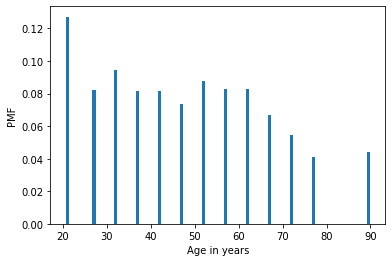

In [35]:
# Extract age
age = brfss.AGE

# Plot the PMF
Pmf.from_seq(age).bar()

# Label the axes
plt.xlabel('Age in years')
plt.ylabel('PMF')
plt.show()

### Scatter plot

Now let's make a scatterplot of weight versus age

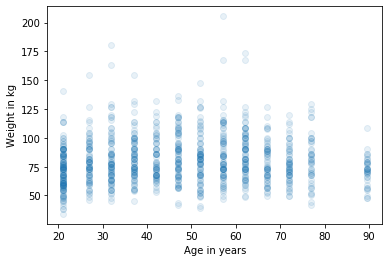

In [36]:
# Select the first 1000 respondents
brfss_1000 = brfss[:1000]

# Extract age and weight
age = brfss_1000['AGE']
weight = brfss_1000['WTKG3']

# Make a scatter plot
plt.plot(age, weight, 'o', alpha=0.1)

plt.xlabel('Age in years')
plt.ylabel('Weight in kg')

plt.show()

### Jittering

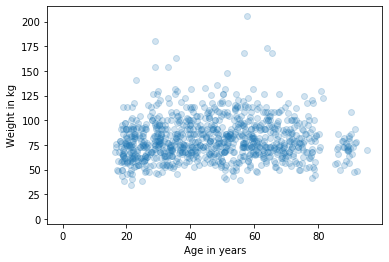

In [37]:
# Add jittering to age
age = brfss_1000['AGE'] + np.random.normal(0, 2.5, size=len(brfss_1000))
# Extract weight
weight = brfss_1000['WTKG3']

# Make a scatter plot
plt.plot(age, weight, 'o', 5, alpha=0.2)

plt.xlabel('Age in years')
plt.ylabel('Weight in kg')
plt.show()

By smoothing out the ages and avoiding saturation, we get the best view of the data. But in this case the nature of the relationship is still hard to see. 

## Visualizing relationships

### Height and weight

The brfss DataFrame contains a variable `'_HTMG10'` that represents height in centimeters, binned into 10 cm groups.

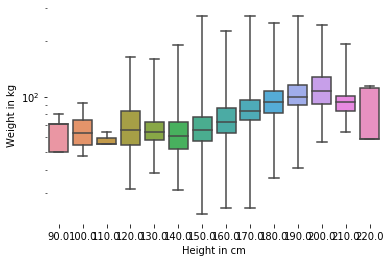

In [38]:
# Drop rows with missing data
data = brfss.dropna(subset=['_HTMG10', 'WTKG3'])

# Make a box plot
sns.boxplot(x="_HTMG10", y="WTKG3", data=data, whis=10)

# Plot the y-axis on a log scale
plt.yscale("log")

# Remove unneeded lines and label axes
sns.despine(left=True, bottom=True)
plt.xlabel('Height in cm')
plt.ylabel('Weight in kg')
plt.show()


These box plots provide a good view of the relationship between the variables. They also show the spread of the values in each column.

### Distribution of income

 we'll look at relationships between income and other variables. In the BRFSS, income is represented as a categorical variable; that is, respondents are assigned to one of 8 income categories. The variable name is 'INCOME2'. Before we connect income with anything else, let's look at the distribution by computing the PMF. 

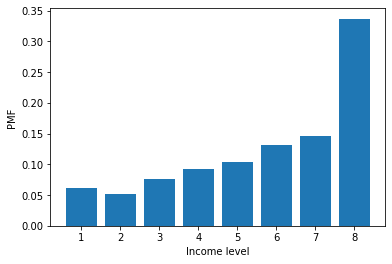

In [39]:
# Extract income
income = brfss.INCOME2

# Plot the PMF
Pmf.from_seq(income).bar()

# Label the axes
plt.xlabel('Income level')
plt.ylabel('PMF')
plt.show()

Almost half of the respondents are in the top income category, so this dataset doesn't distinguish between the highest incomes and the median. But maybe it can tell us something about people with incomes below the median.

### Income and height

Let's now use a violin plot to visualize the relationship between income and height.

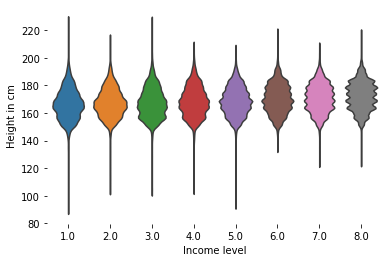

In [40]:
# Drop rows with missing data
data = brfss.dropna(subset=['INCOME2', 'HTM4'])

# Make a violin plot
sns.violinplot(data=data, inner=None, x='INCOME2', y='HTM4')

# Remove unneeded lines and label axes
sns.despine(left=True, bottom=True)
plt.xlabel('Income level')
plt.ylabel('Height in cm')
plt.show()


 It looks like there is a weak positive relationsip between income and height, at least for incomes below the median. 
 
 ## Correlation

### Computing correlations

The purpose of the BRFSS is to explore health risk factors, so it includes questions about diet. The variable `'_VEGESU1'` represents the number of servings of vegetables respondents reported eating per day.

Let's see how this variable relates to age and income.

In [41]:
subset = brfss[['AGE', 'INCOME2', '_VEGESU1']]

# Compute the correlation matrix
subset.corr()

,AGE,INCOME2,_VEGESU1
AGE,1.000000,-0.015158,-0.009834
INCOME2,-0.015158,1.000000,0.119670
_VEGESU1,-0.009834,0.119670,1.000000


the correlation between income and vegetable consumption is about 0.12. The correlation between age and vegetable consumption is about -0.01.

interpretations of these results:
* The correlation between income and vegetable consumption is small, but it suggests that there is a relationship. But a correlation close to 0 does mean there is no relationship.

## Simple Linear regression

### Income and vegetables
the variable `'_VEGESU1'` represents the number of vegetable servings respondents reported eating per day.

Let's estimate the slope of the relationship between vegetable consumption and income.

In [43]:
# Extract the variables
subset = brfss.dropna(subset=['INCOME2', '_VEGESU1'])
xs = subset.INCOME2
ys = subset._VEGESU1

# Compute the linear regression
res = linregress(xs, ys)
res

LinregressResult(slope=0.06988048092104998, intercept=1.5287786243363117, rvalue=0.11967005884864078, pvalue=1.378503916251223e-238, stderr=0.002110976356332331)

The estimated slope tells you the increase in vegetable servings from one income group to the next.

### Fit a line

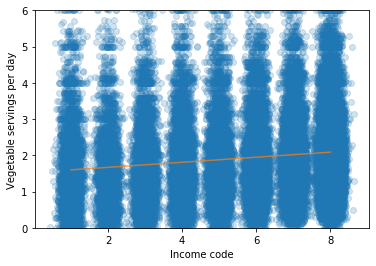

In [44]:
# Plot the scatter plot
plt.clf()
x_jitter = xs + np.random.normal(0, 0.15, len(xs))
plt.plot(x_jitter, ys, 'o', alpha=0.2)

# Plot the line of best fit
fx = np.array([xs.min(), xs.max()])
fy = res.intercept + res.slope*fx
plt.plot(fx, fy, '-', alpha=0.7)

plt.xlabel('Income code')
plt.ylabel('Vegetable servings per day')
plt.ylim([0, 6])
plt.show()

# Multivariate Thinking
Explore multivariate relationships using multiple regression to describe non-linear relationships and logistic regression to explain and predict binary variables.

## Limits of simple regression
